## Import modules

In [1]:
import tensorflow as tf
import numpy as np

tf.random.set_seed(0)

## Loading MNIST

As we did before, we will first load the MNIST dataset.

To use 2d convolutional filters, we do not flatten (reshape) the image.

In [2]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert from uint8 to float32 and
# normalize images value from [0, 255] to [0, 1].
# (uint8: Unsigned integer (0 to 255))
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32) / 255.
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32) / 255.

# add new axis for channel
x_train = tf.reshape(x_train, [-1, 28, 28, 1])
x_test = tf.reshape(x_test, [-1, 28, 28, 1])

print("Image Shape: {}".format(x_train[0].shape))
print("Label Shape: {}".format(y_train[0].shape))
print()
print("Training Set:   {} samples".format(len(x_train)))
print("Test Set:       {} samples".format(len(x_test)))

Image Shape: (28, 28, 1)
Label Shape: ()

Training Set:   60000 samples
Test Set:       10000 samples


## Model: Convolutional Neural network

### Building LeNet-5 with Convolution and Pooling operations

![](https://cdnpythonmachinelearning.azureedge.net/wp-content/uploads/2017/09/lenet-5-825x285.png?x64257)

- conv2d: https://www.tensorflow.org/api_docs/python/tf/contrib/layers/conv2d
- max_pool2d: https://www.tensorflow.org/api_docs/python/tf/contrib/layers/max_pool2d

In [3]:
from tensorflow.keras import Model, layers

In [4]:
# Create CNN Model.
class LeNet(Model):
    # Set layers.
    def __init__(self):
        super(LeNet, self).__init__()
        # convolutional layer
        # input = 28x28x1, output = 24x24x6
        self.conv1 = layers.Conv2D(6, (5, 5), 
                                   padding='VALID', 
                                   activation='relu')
        # pooling layer
        # input = 24x24x6, output = 12x12x6
        self.pool1 = layers.MaxPooling2D(pool_size=2, strides=2)
        # convolutional layer
        # input = 12x12x6, output = 8x8x16
        self.conv2 = layers.Conv2D(16, (5, 5), 
                                   padding='VALID', 
                                   activation='relu')
        # pooling layer
        # input = 8x8x16, output = 4x4x16
        self.pool2 = layers.MaxPooling2D(pool_size=2, strides=2)
        # flatten layer
        # input = 4x4x16, output = 256
        self.flatten = layers.Flatten()
        
        self.dense1 = layers.Dense(120, activation='relu')
        self.dense2 = layers.Dense(84, activation='relu')
        self.out = layers.Dense(10)

    # Set forward pass.
    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.out(x)
        return x

In [5]:
lenet = LeNet()

## Loss function

In [6]:
# Cross-Entropy loss function.
def cross_entropy(y_pred, y_true):
    # Convert labels to int 64 for tf cross-entropy function.
    y_true = tf.cast(y_true, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, 
                                                          logits=y_pred)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

## Optimizer and Batch Generator

In [7]:
# Parameters for Training
learning_rate = 0.1
batch_size = 256
training_steps = 10

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
training_batch = train_data.batch(batch_size).repeat(training_steps)

## Test Metric: Accuracy

In [8]:
# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Training

In [9]:
# Training parameters.
display_step = 500

# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(training_batch, 1):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = lenet(batch_x)
        loss = cross_entropy(pred, batch_y)

    # Compute gradients.
    trainable_variables = lenet.trainable_variables
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    if step % display_step == 0:
        pred = lenet(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 500, loss: 0.062228, accuracy: 0.980469
step: 1000, loss: 0.017019, accuracy: 1.000000
step: 1500, loss: 0.010892, accuracy: 0.996094
step: 2000, loss: 0.016065, accuracy: 1.000000


## Test

In [10]:
# Test model on validation set.
pred = lenet(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.981700


# Visualize the prediction results

In [11]:
# Visualize predictions.
import matplotlib.pyplot as plt
%matplotlib inline

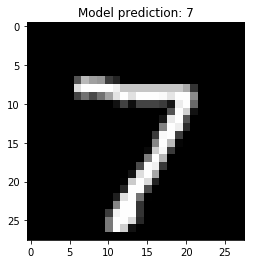

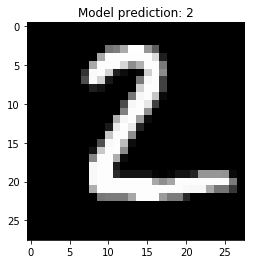

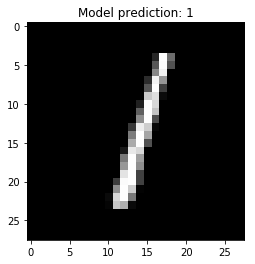

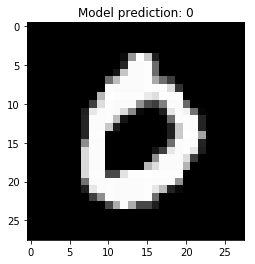

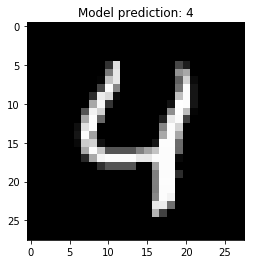

In [12]:
# Predict 5 images from validation set.
n_images = 5
test_images = x_test[:n_images]
predictions = lenet(test_images)

# Display image and model prediction.
for i in range(n_images):
    title = "Model prediction: %i" % np.argmax(predictions.numpy()[i])
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.title(title)
    plt.show()

# [참고] 심플한 코드

In [13]:
# Create CNN Model.
class ProbLeNet(LeNet):
    # Set layers.
    def __init__(self):
        super(ProbLeNet, self).__init__()
        self.out = layers.Dense(10, activation='softmax')

In [14]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# data standardization and type conversion
x_train = x_train.astype(np.float32) / 255.
x_test = x_test.astype(np.float32) / 255.
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

# add new axis for channel
x_train = np.reshape(x_train, [-1, 28, 28, 1])
x_test = np.reshape(x_test, [-1, 28, 28, 1])

# build model
lenet2 = ProbLeNet()

# optimizer, loss, and metric setting in one-step
lenet2.compile(optimizer='SGD',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# training phase
lenet2.fit(x_train, y_train,
           batch_size=batch_size, 
           epochs=training_steps)

# test phase
test_loss, test_accuracy = lenet2.evaluate(x_test, y_test, batch_size=batch_size)
print("Test Loss: %.4f" % test_loss)
print("Test Accuracy: %.4f" % test_accuracy)

# inference
pred_tst = lenet2.predict(x_test, batch_size=batch_size)
print(pred_tst.shape)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 22us/sample - loss: 2.2753 - accuracy: 0.2245
Epoch 2/10
60000/60000 [==============================] - 1s 16us/sample - loss: 1.6266 - accuracy: 0.5956
Epoch 3/10
60000/60000 [==============================] - 1s 16us/sample - loss: 0.4416 - accuracy: 0.8791
Epoch 4/10
60000/60000 [==============================] - 1s 15us/sample - loss: 0.2853 - accuracy: 0.9178
Epoch 5/10
60000/60000 [==============================] - 1s 16us/sample - loss: 0.2316 - accuracy: 0.9322
Epoch 6/10
60000/60000 [==============================] - 1s 16us/sample - loss: 0.1995 - accuracy: 0.9416
Epoch 7/10
60000/60000 [==============================] - 1s 16us/sample - loss: 0.1791 - accuracy: 0.9473
Epoch 8/10
60000/60000 [==============================] - 1s 16us/sample - loss: 0.1631 - accuracy: 0.9521
Epoch 9/10
60000/60000 [==============================] - 1s 15us/sample - loss: 0.1498 - accuracy: 0.9557
Epoch 10/10
60

Test Loss: 0.1264
Test Accuracy: 0.9634
(10000, 10)
